#### Setup

In [21]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import json
import psycopg2
from sqlalchemy.engine.url import URL

# connection to the database
# connection string for use in pandas:
con = str(URL(drivername='postgresql', 
              username=os.environ['DB_QIR_USERNAME'], 
              password=os.environ['DB_QIR_PASSWORD'], 
              #host='www.quantleap.nl', 
              host='localhost', 
              database='qir'))

# cursor for use with psycopg2
conn = psycopg2.connect(con)
cur = conn.cursor()  
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Process Mining of Insolvency Processes
Using process mining we like to get information on the flow of insolvency cases through the court system. 
There are two sources where the state of the insolvency case is logged:

1. structured: in the court publication description and type code
2. unstructuctured: a variety of information in the progress reports


# set start date insolvency using publication.type_code
This field is derived from the publication type code. Certain type codes indicate the start of the insolvency, other the end.


## start date insolvency completeness

In [5]:
sql = """select * from insolvents 
             where person_legal_personality = 'rechtspersoon' 
                   --and is_removed is False 
                   --and (end_findability is null or end_findability > current_date);"""
df_available_insolvents = pd.read_sql(sql, con)


In [6]:
s = df_available_insolvents.start_date_insolvency.notnull()
has_start_date = s.groupby(s).size()
pd.DataFrame({'count': has_start_date, 'pct': has_start_date/has_start_date.sum()})


,count,pct
start_date_insolvency,,
False,3934,0.077554
True,46792,0.922446


### Result discussion
It appears that a small portion of unknown start dates is caused by the left censoring of data: the initial publication relating to the start of the default was not included in the dataset, CIR began slowly in 2010 and only fully around 2014.

But the analysis shown below suggests otherwise, most cases without start date are from the years 2014-2015. Needs further analysis, many cases are transferred to another court.

In [15]:
sql = """with available_insolvents as 
    (select * from insolvents where person_legal_personality = 'rechtspersoon' 
     --and is_removed is False and (end_findability > current_date or end_findability is null)
     ),
  no_start_date_ins as (select * from available_insolvents where start_date_insolvency is NULL),
  min_pub_dates as (select case_number, (select pub.date from publications pub
                                             join insolvents ins on pub.insolvent_id = ins.id
                                             where ins.case_number = no_start_date_ins.case_number
                                             order by pub.date asc
                                             limit 1) as min_pub_date
                    from no_start_date_ins),
  overgedragen as (select distinct i.id, i.case_number from no_start_date_ins i join publications p on p.insolvent_id = i.id
                   where p.type_code = '1334')
select to_char(min_pub_date, 'YYYY') as year_first_available_publication, count(*) from min_pub_dates
group by 1
order by 1;"""
pd.read_sql(sql, con)

,year_first_available_publication,count
0,2005,22
1,2006,55
2,2007,28
3,2008,86
4,2009,145
5,2010,132
6,2011,117
7,2012,58
8,2013,347
9,2014,717


### how do cases start out

In [51]:
sql = """
create temp table publication_types (type_code varchar, description  varchar);
insert into publication_types (type_code, description) values
  ('1100', 'uitspraak faillissement in hoger beroep'),
  ('1200', 'uitspraak faillissement in cassatie'),
  ('1300', 'uitspraak faillissement'),
  ('1301', 'uitspraak faillissement door tussentijdse beëindiging schuldsanering'),
  ('1302', 'uitspraak faillissement tijdens schuldsanering'),
  ('1303', 'uitspraak faillissement door ontbinding akkoord in schuldsanering '),
  ('1304', 'heropening faillissement door ontbinding akkoord in faillissement'),
  ('1305', 'uitspraak faillissement door ontbinding akkoord in surseance'),
  ('1306', 'uitspraak faillissement na beëindiging surseance '),
  ('3313', 'Beëindiging door omzetting in faillissement');
with available_insolvents as 
    (select * from insolvents where person_legal_personality = 'rechtspersoon' 
     --and is_removed is False and (end_findability > current_date or end_findability is null)
     ),
with_start_date_ins as (select * from insolvents where start_date_insolvency is not NULL)
  select pub.type_code, pt.description, count(*)
    from with_start_date_ins ins
      join publications pub on ins.id = pub.insolvent_id
      join publication_types pt on pt.type_code = pub.type_code
    where pub.type_code in ('1100', '1200', '1300', '1301', '1302', '1303', '1304', '1305', '1306', '3313')
  group by 1, 2
order by count desc;
"""
df = pd.read_sql(sql, con)
df.style

,type_code,description,count
0,1300,uitspraak faillissement,57504
1,1306,uitspraak faillissement na beëindiging surseance,2960
2,1301,uitspraak faillissement door tussentijdse beëindiging schuldsanering,2113
3,3313,Beëindiging door omzetting in faillissement,1103
4,1100,uitspraak faillissement in hoger beroep,266
5,1302,uitspraak faillissement tijdens schuldsanering,234
6,1304,heropening faillissement door ontbinding akkoord in faillissement,7
7,1200,uitspraak faillissement in cassatie,3


#### Results
We can determine how cases start out. This can be sliced to a period, court, etc.<br>
Using a stacked area graph it can be shown how cases endings change over time.

### how do cases end

In [16]:
sql = """
create temp table publication_types (type_code varchar, description  varchar);
insert into publication_types (type_code, description) values
('1102', 'vernietiging faillissement in hoger beroep'),
('1202', 'vernietiging faillissement in cassatie'),
('1316', 'opheffing faillissement wegens gebrek aan baten'),
('1317', 'einde faillissement door verbindende uitdelingslijst'),
('1318', 'einde faillissement door goedkeuring akkoord'),
('1319', 'einde faillissement door verbindende uitdelingslijst na verzet'),
('1320', 'vernietiging faillissement na verzet'),
('1324', 'einde faillissement door voldoen van alle schulden'),
('1333', 'Faillissement omgezet in schuldsanering');

with available_insolvents as 
    (select * from insolvents where person_legal_personality = 'rechtspersoon' 
     --and is_removed is False and (end_findability > current_date or end_findability is null)
     ),
with_end_date_ins as (select * from insolvents where end_date_insolvency is not NULL)
  select pub.type_code, pt.description, count(*)
    from with_end_date_ins ins
      join publications pub on ins.id = pub.insolvent_id
      join publication_types pt on pt.type_code = pub.type_code
    where pub.type_code in ('1102', '1202', '1316', '1317', '1318', '1319', '1320', '1324', '1333')
  group by 1, 2
order by count desc;
"""
df = pd.read_sql(sql, con)
df.style.set_properties()

,type_code,description,count
0,1316,opheffing faillissement wegens gebrek aan baten,31525
1,1317,einde faillissement door verbindende uitdelingslijst,10571
2,1333,Faillissement omgezet in schuldsanering,3133
3,1318,einde faillissement door goedkeuring akkoord,814
4,1320,vernietiging faillissement na verzet,727
5,1102,vernietiging faillissement in hoger beroep,214
6,1319,einde faillissement door verbindende uitdelingslijst na verzet,39
7,1324,einde faillissement door voldoen van alle schulden,9
8,1202,vernietiging faillissement in cassatie,6


## Intermediate states
Apart from beginning and end state many intermediate states can be identified from the data. One example is the moment of setting the verification meeting for which a timing constraint is set by the law.

### when are verification meetings set
Verfification meetings are supposed to be schedules (not held) within 14 days after the publication of bankruptcy. This demand is seen as a dead letter to be changed with the new law from 2019-1-1 onwards. From the distribution is can be seen that this deadline is almost never met, on the contrary, it appears breached up to a point that it needs further inspection.

In [37]:
sql = """
with available_insolvents as
  (select * from insolvents where person_legal_personality = 'rechtspersoon'
                             and start_date_insolvency is not null
                             and is_removed is False
                             and (end_findability > current_date or end_findability is null)
                             --limit 1000
  ),
  min_pub_dates as (select case_number, (select min(p.date) from publications p
                                             join available_insolvents i2 on p.insolvent_id = i2.id
                                             where i2.id = i1.id
                                               and p.type_code in ('1309', '1310', '1325', '1326',
                              '2310', '2311', '2312', '2313', '2314', '2315', '2316', '2317', '2318',
                              '2338', '2339', '2340', '2341', '2342', '2343', '2344', '2345', '2346', '2347')
                                             ) as min_pub_date,
                           start_date_insolvency
                    from available_insolvents i1)
select start_date_insolvency, case_number, min_pub_date - start_date_insolvency as days_after_start
from min_pub_dates where min_pub_date is not null
order by 1 desc, 2, 3 desc;"""
df = pd.read_sql(sql, con)

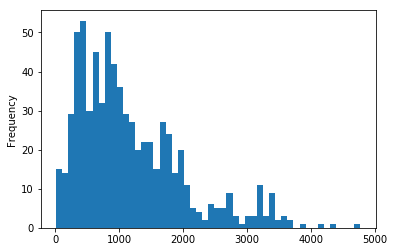

In [38]:
df.days_after_start.plot.hist(bins=50)

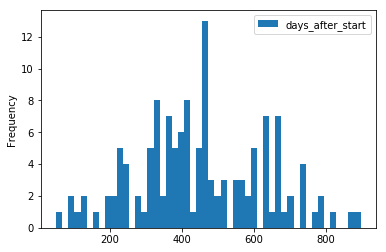

In [45]:
# see recent breaches
df[df.start_date_insolvency > datetime.date(2016, 1, 1)].plot.hist(bins=50)

# this data is right censored, cases which not yet had a verification meeting publication are not seen.

In [46]:
# see recent breaches
import datetime
df[df.start_date_insolvency > datetime.date(2016, 1, 1)].sort_values(by=['days_after_start'], ascending=False).head(20)

,start_date_insolvency,case_number,days_after_start
130,2016-01-19,F.13/16/28,895
126,2016-01-26,F.03/16/31,875
124,2016-02-02,F.09/16/61,819
125,2016-02-02,F.09/16/65,793
121,2016-02-09,F.10/16/97,784
115,2016-03-08,F.16/16/164,764
84,2016-06-14,F.05/16/398,738
85,2016-06-14,F.05/16/399,738
111,2016-03-15,F.09/16/161,728
83,2016-06-15,F.15/16/241,728


In [50]:
# pull a file e.g. the second
sql = """
select case_number, date, type_code, description, start_date_insolvency
from insolvents i join publications p on i.id = p.insolvent_id
where case_number = 'F.03/16/31'
order by date;
"""
pd.read_sql(sql, con).style

,case_number,date,type_code,description,start_date_insolvency
0,F.03/16/31,2016-01-28,1300,Uitspraak faillissement op 26 januari 2016,2016-01-26
1,F.03/16/31,2016-11-24,1307,vervanging curator mr. B.P.J. Tillemans door mr. J.T.J. Gorissen,2016-01-26
2,F.03/16/31,2017-05-08,1328,vervanging rechter-commissaris mr. M.E.M.W. Nuijts door mr. J.J. Groen.,2016-01-26
3,F.03/16/31,2018-06-19,1309,Verificatievergadering: op 26 juni 2018 om 11:30,2016-01-26
